In [30]:
import pickle
import sys
from typing import cast

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

sys.path.append("..")
from path import DATA_DIR, RESULT_DIR
from traffic.data import StandardScaler, TrafficDataset, preprocess

plt.rcParams.update(
    {
        "font.family": "FreeSerif",
        "mathtext.default": "regular",
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
        "font.size": 20,
        "axes.titlesize": 20,
        "axes.labelsize": 20,
        "legend.fontsize": 20,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
    }
)

window = 12
exp_id = "traffic"

In [4]:
def inverse_transform(x: torch.Tensor, scaler: StandardScaler) -> torch.Tensor:
    return scaler.inverse_transform(x.reshape(-1, 1)).reshape(x.shape)


# Load true trajectory
df = cast(pd.DataFrame, pd.read_hdf(DATA_DIR / "PEMS-BAY/pems-bay.h5"))
*_, adj = pd.read_pickle(DATA_DIR / "PEMS-BAY/adj_mx_bay.pkl")
preprocessed = preprocess(df, adj)

trajectory = preprocessed["trajectory"]
time_in_day = preprocessed["time_in_day"]
day_in_week = preprocessed["day_in_week"]
edge_indices = preprocessed["edge_index"]
edge_attrs = preprocessed["edge_attr"]
indicies_test = preprocessed["indicies_test"]
scaler = preprocessed["scaler"]

num_nodes = trajectory.shape[1]
timestamp = df.index.values[indicies_test[:, 2]-1]

test_dataset = TrafficDataset(
    trajectory, time_in_day, day_in_week, indicies_test, edge_indices, edge_attrs
)
true_trajectory = inverse_transform(
    torch.cat([data.y[..., window - 1] for data in test_dataset.data], dim=0),
    scaler,
).numpy()

# Load predicted trajectory
result_dir = RESULT_DIR / exp_id
with open(result_dir / "pred_trajectory.pkl", "rb") as f:
    pred_trajectories = pickle.load(f)
pred_trajectory = pred_trajectories[window]

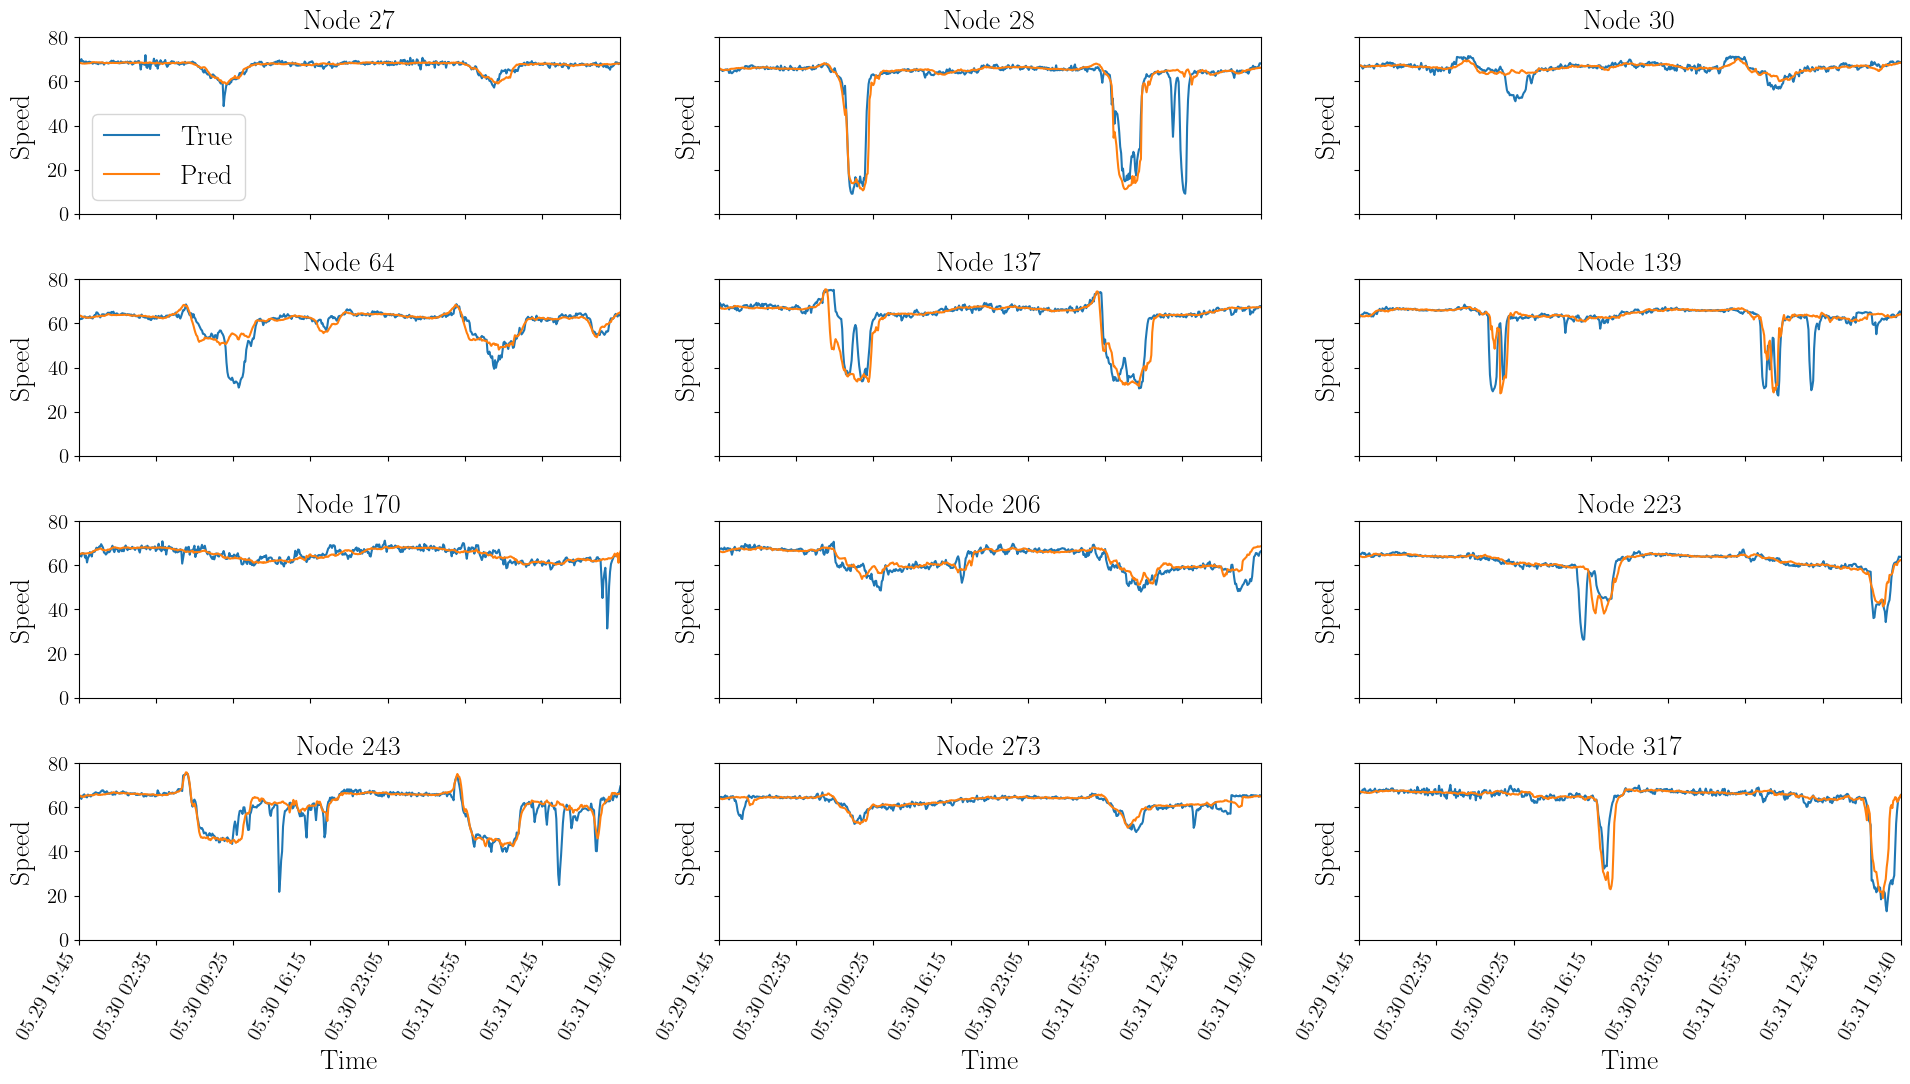

In [99]:
plot_steps = slice(288 * 4, 288 * 6)  # 2 days
timestamp_plot = timestamp[plot_steps]

fig, axes = plt.subplots(4, 3, figsize=(20, 12), sharex=True, sharey=True)
tick_idx = np.linspace(0, len(timestamp_plot) - 1, 8).astype(np.int64)
rng = np.random.default_rng(42)
random_nodes = rng.choice(num_nodes, 12, replace=False)
random_nodes.sort()

for i, (node, ax) in enumerate(zip(random_nodes, axes.flatten())):
    ax.plot(timestamp_plot, true_trajectory[plot_steps, node], label="True")
    ax.plot(timestamp_plot, pred_trajectory[plot_steps, node], label="Pred")

    ax.set_title(f"Node {node}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed", labelpad=10)
    ax.set_xlim(timestamp_plot[0], timestamp_plot[-1])

    ax.set_xticks(timestamp_plot[tick_idx])
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m.%d %H:%M"))
    ax.set_yticks([0, 20, 40, 60, 80])

    if i == 0:
        ax.legend()

fig.tight_layout(w_pad=0.0, h_pad=0.5)
fig.autofmt_xdate(rotation=60)
fig.savefig("figS3.pdf", bbox_inches="tight")
fig.show()